In [153]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, root_mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
import seaborn as sns

In [154]:
file_path = r"C:\Users\Sina Fadakhah\Desktop\Divar 2\divar_almost_clean.csv"

# Read the file
df = pd.read_csv(file_path)

df.head(2)

,area_sqm,building_year,num_rooms,has_elevator,has_parking,has_storage,price(in_toman),floor_number,district
0,92,1370,2,No,Yes,No,10500000000,23.0,گیشا (کوی نصر)
1,250,1397,4,Yes,Yes,Yes,50000000000,4.0,سعادت‌آباد


## Preprocessing Data

In [155]:
df = df.dropna(subset=['floor_number'])
df['floor_number'] = df['floor_number'].astype(int)

In [156]:
# Initialize the LabelEncoder
encoder = LabelEncoder()

# Encode the 'district' column and store it in a new column
df['district_encoded'] = encoder.fit_transform(df['district'])
df['has_elevator'] = encoder.fit_transform(df['has_elevator'])
df['has_parking'] = encoder.fit_transform(df['has_parking'])
df['has_storage'] = encoder.fit_transform(df['has_storage'])

- The Price Filter ensures that only properties priced between 1 billion Tomans and 190 billion Tomans are included. This removes unrealistic or outlier prices, excluding properties priced too low (which are unlikely to be typical residential apartments in Tehran) and those priced too high (which may represent luxury or commercial properties). The Area Filter focuses on apartments with sizes between 25 square meters and 280 square meters, excluding properties that are too small (likely studios or non-residential spaces) or too large (likely luxury properties or penthouses). Together, these filters refine the dataset to represent standard residential apartments, improving data quality and ensuring the model aligns with real-world expectations.

In [157]:
# Filter the DataFrame
df = df[(df['price(in_toman)'] > 1000000000) & (df['price(in_toman)'] < 190000000000)]
df = df[(df['area_sqm'] < 280) & (df['area_sqm'] > 25)]

In [158]:
# Initialize StandardScaler
scaler = StandardScaler()

# Fit and transform the price column
df['price_standardized'] = scaler.fit_transform(df[['price(in_toman)']])

In [159]:
current_year = 1403
df['building_age'] = current_year - df['building_year']

In [160]:
#df = df.sort_values(by='price(in_toman)', ascending=True)
#df.head(5)  # Adjust the number of rows to display as needed

## Training

In [161]:
# Features (X) and Target (y)
X = df[['area_sqm', 'building_age', 'num_rooms', 'has_elevator', 'has_parking', 'has_storage', 'district_encoded','floor_number']]
y = df['price(in_toman)']

# Step 2: Split the Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

# Step 3: Train the Model
model = XGBRegressor(random_state=42, n_estimators=300, learning_rate=0.2, max_depth=3)  # You can tune hyperparameters
model.fit(X_train, y_train)

# Step 4: Evaluate the Model
y_pred = model.predict(X_test)

# Metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)  # Use root_mean_squared_error
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R² Score: {r2}")

# Step 5: Feature Importance
print("\nFeature Importance:")
for feature, importance in zip(X.columns, model.feature_importances_):
    print(f"{feature}: {importance}")

Mean Absolute Error (MAE): 2798170983.7288136
Mean Squared Error (MSE): 2.0095382488833462e+19
Root Mean Squared Error (RMSE): 4482787357.084146
R² Score: 0.8615052700042725

Feature Importance:
area_sqm: 0.6324877738952637
building_age: 0.0932236984372139
num_rooms: 0.03716662898659706
has_elevator: 0.056676410138607025
has_parking: 0.028987428173422813
has_storage: 0.03646690398454666
district_encoded: 0.05929378792643547
floor_number: 0.05569739639759064


In [162]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='r2')
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)

{'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 300}


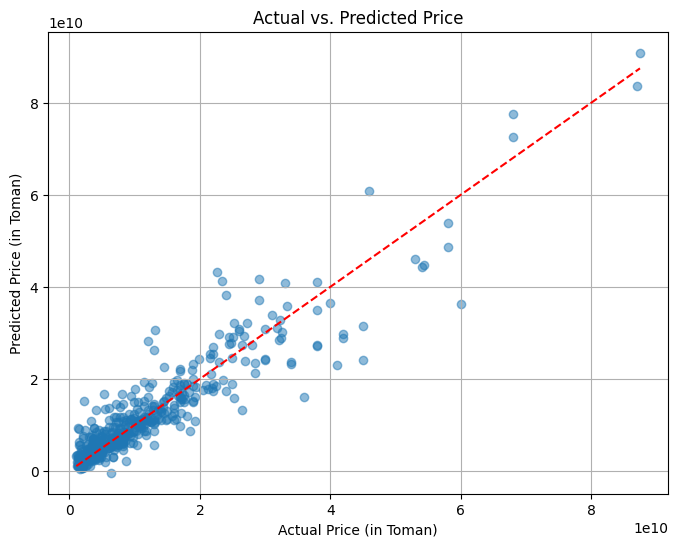

In [163]:
import matplotlib.pyplot as plt

# Plot actual vs. predicted values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')  # 45-degree line
plt.xlabel('Actual Price (in Toman)')
plt.ylabel('Predicted Price (in Toman)')
plt.title('Actual vs. Predicted Price')
plt.grid(True)
plt.show()

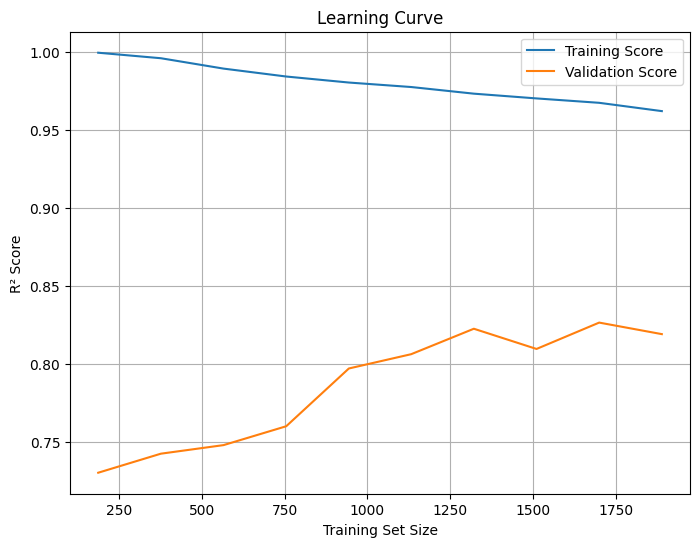

In [164]:
# Calculate learning curve
train_sizes, train_scores, val_scores = learning_curve(
    model, X, y, cv=5, scoring='r2', train_sizes=np.linspace(0.1, 1.0, 10)
)

# Plot learning curve
plt.figure(figsize=(8, 6))
plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Training Score')
plt.plot(train_sizes, np.mean(val_scores, axis=1), label='Validation Score')
plt.xlabel('Training Set Size')
plt.ylabel('R² Score')
plt.title('Learning Curve')
plt.legend()
plt.grid(True)
plt.show()

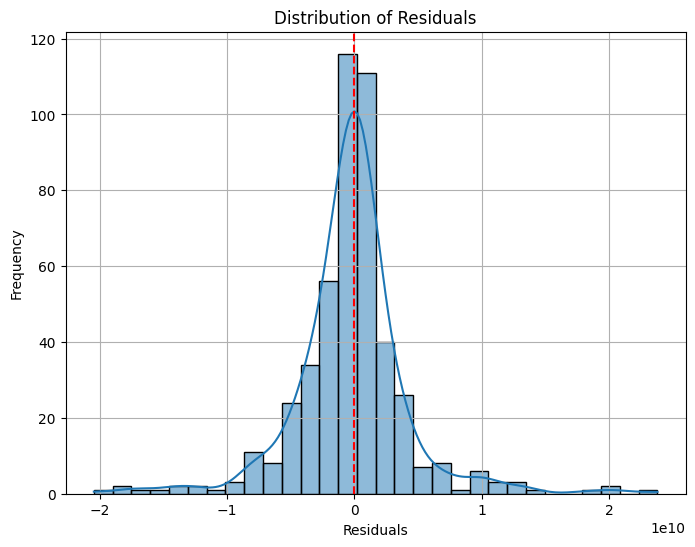

In [165]:
residuals = y_test - y_pred

# Plot distribution of residuals
plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True, bins=30)
plt.axvline(x=0, color='red', linestyle='--')  # Zero residual line
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')
plt.grid(True)
plt.show()

<Figure size 800x600 with 0 Axes>

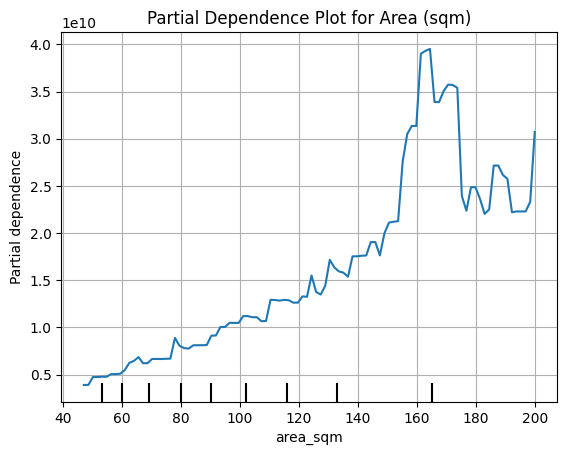

In [166]:
from sklearn.inspection import PartialDependenceDisplay

# Plot partial dependence for a feature (e.g., area_sqm)
plt.figure(figsize=(8, 6))
PartialDependenceDisplay.from_estimator(model, X_train, features=['area_sqm'])
plt.title('Partial Dependence Plot for Area (sqm)')
plt.grid(True)
plt.show()

In the range of 150 to 180 square meters, we observe sharp increases and decreases in the curve, which could indicate the presence of outliers or anomalies in the data. These sudden changes may suggest that the model is reacting to unusual or extreme values in this specific range, which do not follow the general trend observed in other parts of the data.